In [1]:
# Step 1: Install necessary libraries
!pip install yfinance xgboost

# Step 2: Import libraries
import yfinance as yf
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
# Step 3: Fetch AAPL data
ticker = "AAPL"
data = yf.download(ticker, start="2022-05-01", end="2024-11-25")  # Adjust dates if needed

# Step 4: Feature Engineering
data['Return'] = data['Close'].pct_change()  # Daily returns
data['SMA_10'] = data['Close'].rolling(window=10).mean()  # 10-day Simple Moving Average
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_100'] = data['Close'].rolling(window=100).mean()
data['Volatility'] = data['Return'].rolling(window=16).std()  # Rolling Volatility
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()  # Exponential Moving Average (EMA)
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + data['Return'].rolling(window=10).mean() / data['Return'].rolling(window=14).std()))  # RSI

# Drop rows with missing values caused by rolling calculations
data.dropna(inplace=True)

# Target Variable
data['Target'] = data['Close'].shift(-1)  # Next day's price as target
data.dropna(inplace=True)

# Preview the processed data
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_10,SMA_50,SMA_100,Volatility,EMA_10,EMA_50,RSI,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,
Date,,,,,,,,,,,,,,,
2022-09-22,150.900192,152.740005,154.470001,150.910004,152.380005,86652500,-0.006375,155.085997,160.1666,152.1416,0.022603,154.881904,157.382326,-3.240269,150.429993
2022-09-23,148.617996,150.429993,151.470001,148.559998,151.190002,96029900,-0.015124,154.391997,160.2058,152.0663,0.022742,154.072466,157.109686,-20.765650,150.770004
2022-09-26,148.953918,150.770004,153.770004,149.639999,149.660004,93339400,0.002260,153.125998,160.2178,151.9792,0.022698,153.472018,156.861071,-47.611905,151.759995
2022-09-27,149.931992,151.759995,154.720001,149.949997,152.740005,84442700,0.006566,152.917998,160.3116,151.8366,0.022610,153.160741,156.661029,-5.499440,149.839996
2022-09-28,148.035110,149.839996,150.639999,144.839996,147.639999,146691400,-0.012652,152.370998,160.2884,151.7673,0.022726,152.556969,156.393537,-16.821990,142.479996


In [3]:
# Step 5: Train-Test Split
train_data = data[0:int(len(data) * 0.84)]  # Train on the first 84%
test_data = data[int(len(data) * 0.84):]    # Test on the remaining 16%

# Features and Target
X_train = train_data[['Close', 'SMA_10', 'SMA_50', 'SMA_100', 'Volatility', 'EMA_10', 'EMA_50', 'RSI']].values
y_train = train_data['Target'].values
X_test = test_data[['Close', 'SMA_10', 'SMA_50', 'SMA_100', 'Volatility', 'EMA_10', 'EMA_50', 'RSI']].values
y_test = test_data['Target'].values

# Confirm sizes
print(f"Training data size: {X_train.shape}, {y_train.shape}")
print(f"Testing data size: {X_test.shape}, {y_test.shape}")


Training data size: (458, 8), (458,)
Testing data size: (88, 8), (88,)


In [4]:
# Step 6: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print sample scaled values
print("Sample scaled feature values:", X_train_scaled[0])


Sample scaled feature values: [-0.92929245 -0.82336351 -0.56029543 -0.98697047  1.24096315 -0.8387772
 -0.72776723  0.06998424]


In [5]:
# Step 7: Define XGBoost Model and Parameter Grid
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform Grid Search with TimeSeriesSplit
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='r2', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Retrieve best model
best_model = grid_search.best_estimator_
print(f"Best Parameters from Grid Search: {grid_search.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters from Grid Search: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


In [6]:
# Step 8: Predictions
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Metrics
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"R-squared on Test Data: {r2_test}")
print(f"Mean Absolute Error on Test Data: {mae_test}")
print(f"Mean Squared Error on Test Data: {mse_test}")
print(f"Mean Absolute Percentage Error on Test Data: {100 * mape_test}%")

# Print training and testing date ranges
training_start_date = train_data.index[0].strftime('%B %Y')
training_end_date = train_data.index[-1].strftime('%B %Y')
testing_start_date = test_data.index[0].strftime('%B %Y')
testing_end_date = test_data.index[-1].strftime('%B %Y')

print(f"\nTraining Data Duration: {training_start_date} to {training_end_date}")
print(f"Testing Data Duration: {testing_start_date} to {testing_end_date}")


R-squared on Test Data: 0.4592459953664376
Mean Absolute Error on Test Data: 3.14672868902033
Mean Squared Error on Test Data: 17.585628501861887
Mean Absolute Percentage Error on Test Data: 1.3976618003625525%

Training Data Duration: September 2022 to July 2024
Testing Data Duration: July 2024 to November 2024


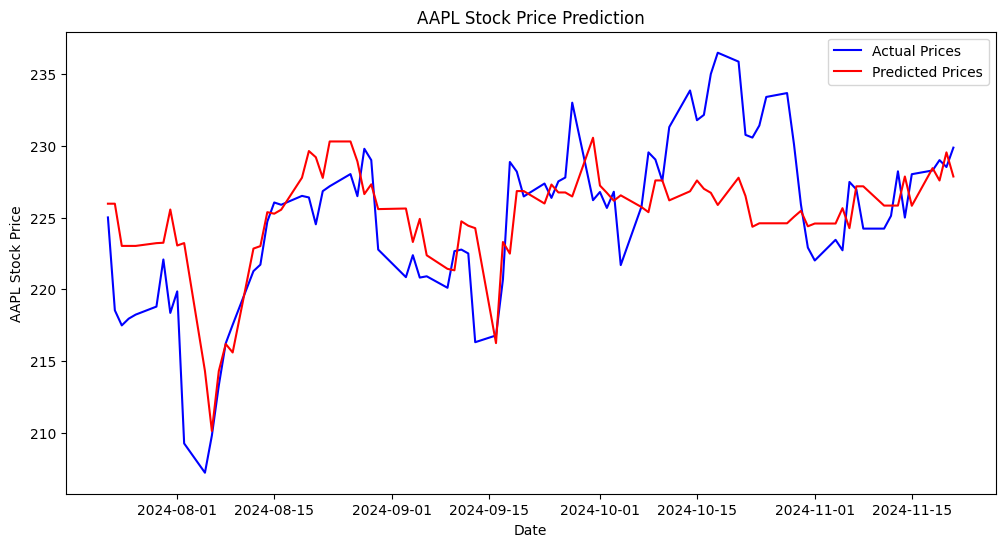

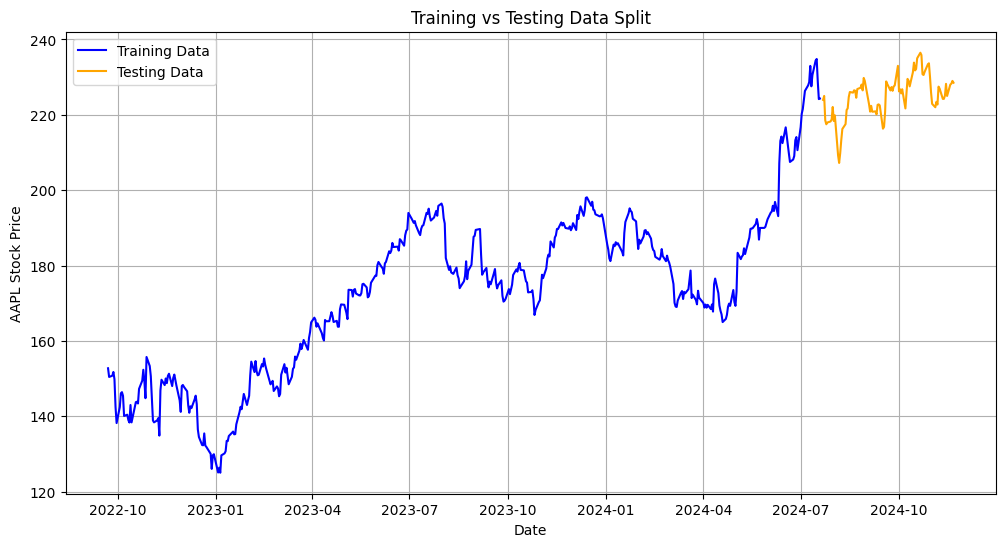

In [7]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label="Actual Prices", color='blue')
plt.plot(test_data.index, y_pred_test, label="Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.legend()
plt.show()

# Plot Training vs Testing Data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label="Training Data", color='blue')
plt.plot(test_data.index, test_data['Close'], label="Testing Data", color='orange')
plt.xlabel("Date")
plt.ylabel("AAPL Stock Price")
plt.title("Training vs Testing Data Split")
plt.legend()
plt.grid()
plt.show()
